In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils

In [2]:
import json
import cv2

In [3]:
from skimage import io, transform

In [4]:
with open("../data/barry_marta_shoes.json","r") as f:
    annotation_dict = json.load(f)

In [141]:
annotation_dict.keys()

dict_keys(['29804870257.jpg97295', '30204268977.jpg194047', '31007999967.jpg197006', '31008001497.jpg166328', '31114721337.jpg108316', '31168615557.jpg107657', '31268763408.jpg121970', '31269051448.jpg130394', '31313977097.jpg170983', '31396126638.jpg121669', '31397037568.jpg117420', '31397167158.jpg133024', '31463394047.jpg116783', '31518335457.jpg133985', '32033517157.jpg112904', '32037558177.jpg174349', '32037602807.jpg278141', '32037616357.jpg240739', '32076043128.jpg110257', '32081559227.jpg245989', '32114499097.jpg206053', '32116408707.jpg144957', '32132795597.jpg246292', '32153049317.jpg222428', '32300723617.jpg121612', '32393592178.jpg110262', '32397934297.jpg158925', '32423634288.jpg159719', '32540854658.jpg103942', '32540855948.jpg103135', '32610611847.jpg140817', '32634000067.jpg126639', '32640225577.jpg255867', '32640265457.jpg234728', '32648995547.jpg168381', '32671401638.jpg119320', '32671403048.jpg113164', '32718051428.jpg152596', '32734177088.jpg132076', '32802479237.jp

In [123]:
landmarks_frame = pd.read_csv('../data/faces/face_landmarks.csv')

In [124]:
landmarks_frame

,image_name,part_0_x,part_0_y,part_1_x,part_1_y,part_2_x,part_2_y,part_3_x,part_3_y,part_4_x,...,part_63_x,part_63_y,part_64_x,part_64_y,part_65_x,part_65_y,part_66_x,part_66_y,part_67_x,part_67_y
0,0805personali01.jpg,27,83,27,98,29,113,33,127,39,...,93,136,100,141,93,135,89,135,84,134
1,1084239450_e76e00b7e7.jpg,70,236,71,257,75,278,82,299,90,...,148,311,179,308,149,312,137,314,128,312
2,10comm-decarlo.jpg,66,114,65,128,67,142,68,156,72,...,128,162,136,167,127,166,121,165,116,164
3,110276240_bec305da91.jpg,42,140,45,161,51,180,61,200,73,...,144,197,180,189,147,204,136,208,125,209
4,1198_0_861.jpg,138,392,141,427,145,464,152,501,166,...,293,507,331,511,294,516,279,518,265,516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,matt-mathes.jpg,85,152,83,173,83,195,85,217,91,...,160,224,190,225,162,236,151,237,141,235
65,person-7.jpg,32,65,33,76,34,86,34,97,37,...,79,98,91,99,79,99,74,99,69,99
66,person.jpg,78,83,79,93,80,103,81,112,85,...,119,115,132,114,120,121,114,122,109,121
67,person_TjahjonoDGondhowiardjo.jpg,41,92,41,103,43,114,44,125,48,...,85,130,94,130,85,128,81,128,77,128


In [4]:
def get_im_annon(key,anon_dict):
    
    im_key = [akey for akey in anon_dict.keys() if key in akey]
    
    
    adict = {}
    adict["filename"] = key
    
    adict["objects"] = {}

    
    i = 1
    
    for shape in anon_dict[im_key[0]]["regions"]:
        adict["objects"][f"object_{i}"] = np.array(list(zip(shape["shape_attributes"]["all_points_x"],shape["shape_attributes"]["all_points_y"])))
        
        i+=1
    
    return adict

def plot_mask(anon_dict):
    
    plt.plot(anon_dict[:,0],anon_dict[:,1])
#     plt.show()



def plot_data(image ,anon_dict, figsize = (10,10)):
    
#     image = cv2.imread(f"../data/all_data/{filename}")
    
    plt.figure(figsize=figsize)
    
#     anon_dict = get_im_annon(filename,anon_dict)
    
#     plt.imshow(image)
    
    for i in range(len(anon_dict)):
        plot_mask(anon_dict)
    plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
    plt.show()

In [252]:
class ShoeDataset(Dataset):
    
    def __init__(self,json_file, root_dir, transform = None):
        
        with open("../data/barry_marta_shoes.json","r") as f:
            self.objects = json.load(f)
        
        self.root_dir = root_dir
        self.transform = transform
        
        
    def __len__(self):
        return len(self.objects.keys())
    
    
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        item = get_im_annon(idx,self.objects)
        name = item["filename"].split("g")[0]+"g"

        img_name = os.path.join(self.root_dir,name)
        print("img name", img_name)
        
#         image = io.imread(img_name)
        image = cv2.imread(img_name)

        objects = np.concatenate(list(item["objects"].values()))

        sample = {"image" : image,"objects":objects}

        if self.transform:
            sample = self.transform(sample)
                
        return sample
            
            

In [253]:
shoe_dataset = ShoeDataset(json_file="../data/barry_marta_shoes.json",
                                    root_dir='../data/all_data/')


idx 29804870257.jpg97295
img name ../data/all_data/29804870257.jpg
0 (1024, 683, 3) (35, 2)


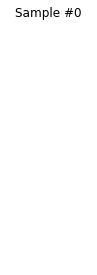

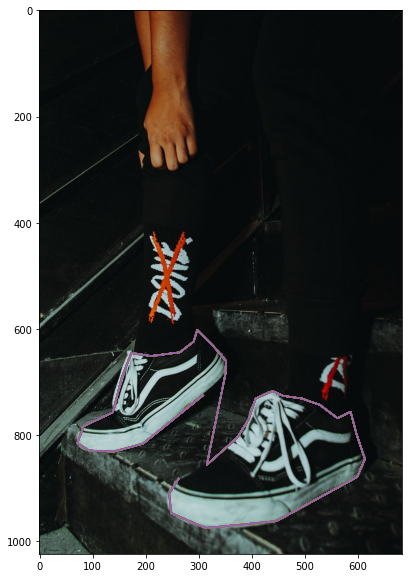

idx 30204268977.jpg194047
img name ../data/all_data/30204268977.jpg
1 (684, 1024, 3) (47, 2)


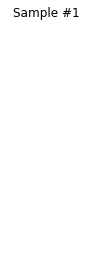

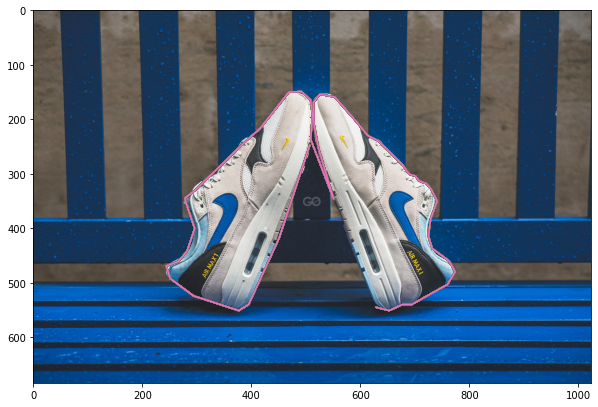

idx 31007999967.jpg197006
img name ../data/all_data/31007999967.jpg
2 (684, 1024, 3) (53, 2)


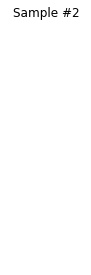

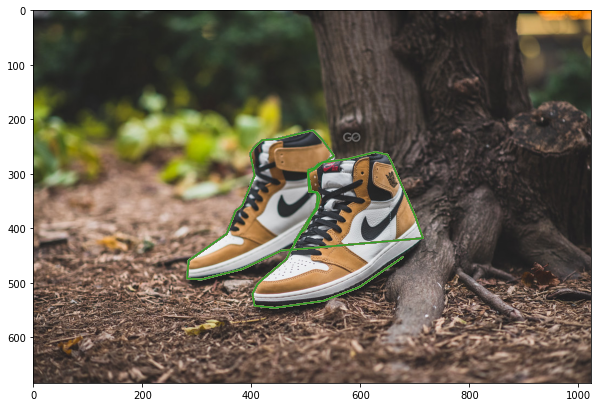

idx 31008001497.jpg166328
img name ../data/all_data/31008001497.jpg
3 (684, 1024, 3) (53, 2)


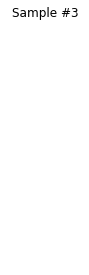

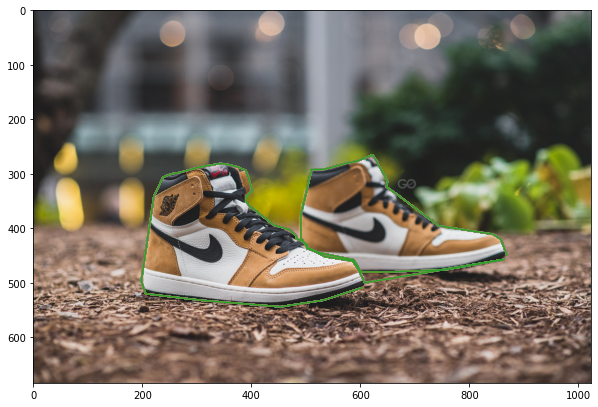

In [254]:
fig = plt.figure()

for i in range(len(shoe_dataset)):
    idx = list(shoe_dataset.objects.keys())[i]
    print("idx",idx)
    sample = shoe_dataset[idx]


    print(i, sample['image'].shape, sample['objects'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plot_data(image=sample["image"],anon_dict=sample["objects"])

    if i == 3:
        plt.show()
        break

In [255]:
"""








""";

In [5]:
import imageio
import imgaug as ia
from imgaug.augmentables.polys import Polygon, PolygonsOnImage
from imgaug import augmenters

In [24]:
image = imageio.imread("../data/all_data/29804870257.jpg")
# image = ia.imresize_single_image(image,0.7)

In [25]:
type(image)

imageio.core.util.Array

In [269]:
"""

Import Polygon and PolygonsOnImage classes and create polygon instances

""";

In [ ]:
"""

Brightness,
Flip,
Add Gauss Noise,
AddToHueandSaturation,
Perspective Transform,

"""

In [13]:
shoe_sample = get_im_annon("29804870257.jpg",annotations_dict)
shoe_sample

{'filename': '29804870257.jpg',
 'objects': {'object_1': array([[308, 725],
         [195, 816],
         [140, 831],
         [ 93, 829],
         [ 71, 815],
         [ 83, 783],
         [138, 757],
         [155, 691],
         [173, 645],
         [209, 651],
         [264, 644],
         [290, 624],
         [297, 602],
         [328, 633],
         [351, 660],
         [350, 685]]),
  'object_2': array([[315, 856],
         [372, 805],
         [394, 770],
         [407, 731],
         [439, 717],
         [459, 726],
         [494, 731],
         [528, 743],
         [561, 768],
         [586, 756],
         [597, 798],
         [613, 845],
         [598, 879],
         [510, 927],
         [446, 962],
         [313, 975],
         [248, 947],
         [244, 910],
         [262, 882]])}}

In [15]:
left_shoe = Polygon(shoe_sample["objects"]["object_1"])
right_shoe = Polygon(shoe_sample["objects"]["object_2"])

In [16]:
image_polys = np.copy(image)
image_polys = left_shoe.draw_on_image(image_polys,alpha_face = 0.2, size_points = 7)
image_polys = right_shoe.draw_on_image(image_polys, alpha_face = 0.2, size_points = 7)

# ia.imshow(image_polys)

In [17]:
psoi = PolygonsOnImage([left_shoe,right_shoe],shape = image.shape)

In [30]:
"""

Brightness,
Flip,
Add Gauss Noise,
AddToHueandSaturation,
Perspective Transform,

"""

'\n\nBrightness,\nFlip,\nAdd Gauss Noise,\nAddToHueandSaturation,\nPerspective Transform,\n\n'

In [18]:
aug = augmenters.Sequential([
    augmenters.color.MultiplyAndAddToBrightness(),
    augmenters.Fliplr(p = 0.7),
    augmenters.AddToHueAndSaturation((-20, 20)),
    augmenters.PerspectiveTransform((0.01, 0.1))
    ])

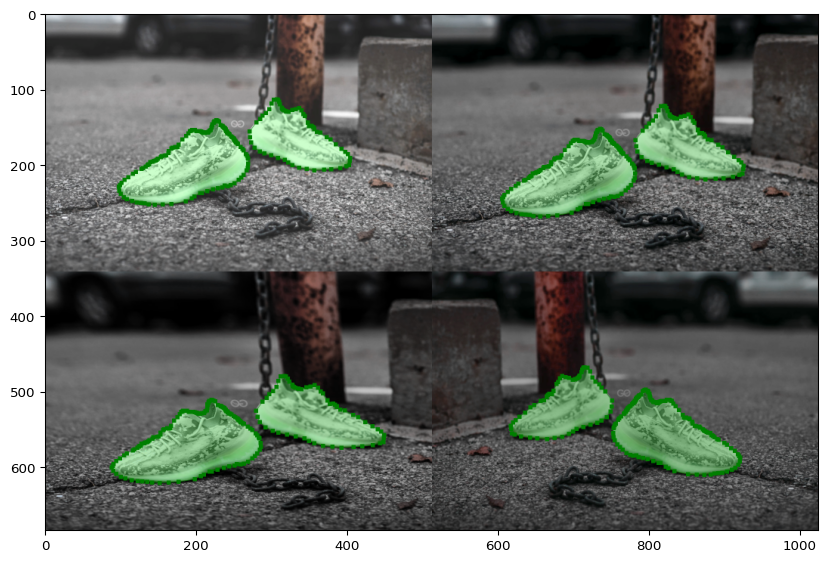

In [21]:
images_polys_aug = []
images_aug = []
psoi_aug_list = []
for _ in range(2*2):
    image_aug, psoi_aug = aug(image=image, polygons=psoi)
    images_aug.append(image_aug)
    psoi_aug_list.append(psoi_aug)
    image_polys_aug = psoi_aug.draw_on_image(image_aug, alpha_face=0.2, size_points=11)
    images_polys_aug.append(ia.imresize_single_image(image_polys_aug, 0.5))

ia.imshow(ia.draw_grid(images_polys_aug, cols=2))

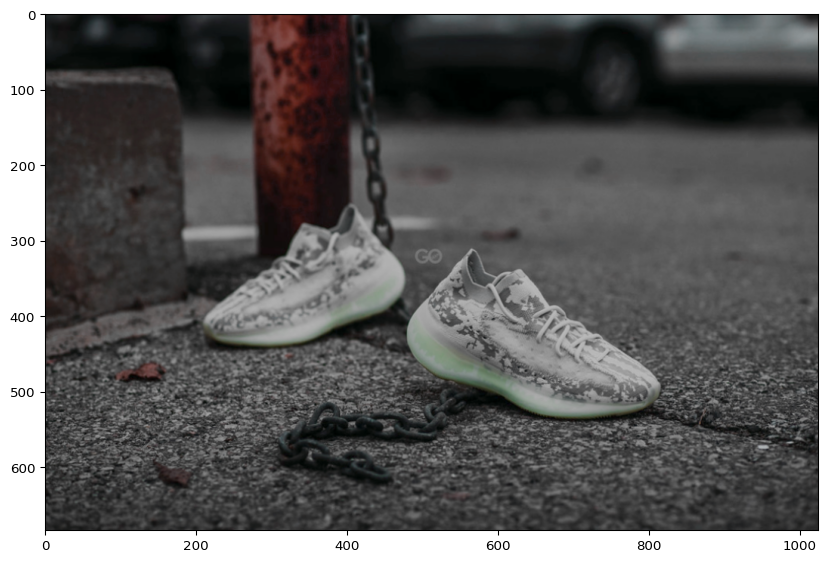

In [22]:
ia.imshow(image_aug)

In [16]:
len(image_aug)

684

In [66]:
chuj = psoi_aug_list[1]

In [61]:
images_aug[0].shape

(1024, 683, 3)

In [67]:
kurwa = chuj.draw_on_image(np.copy(images_aug[1]), alpha_face = 0.2, size_points=7)

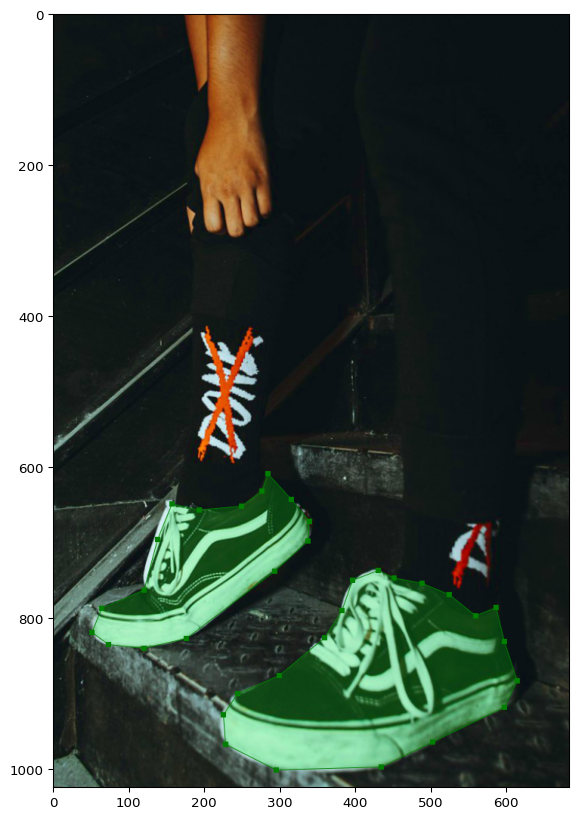

In [68]:
ia.imshow(kurwa)

In [7]:
"""






""";

In [6]:
all_annotated_img_filenames = [name for name in os.listdir("../data/data/annotated_images/") if ".jpg" in name]

In [7]:
with open("../data/data/annotated_images/annotations.json","r" ) as file:
    
    annotations_dict = json.load(file)

In [8]:
aug = augmenters.Sequential([
    augmenters.color.MultiplyAndAddToBrightness(),
    augmenters.Fliplr(p = 0.7),
    augmenters.AddToHueAndSaturation((-20, 20)),
    augmenters.PerspectiveTransform((0.01, 0.1))
    ])

In [83]:
aug_dict = {}

In [ ]:
class CloneCreptron:
    
    def __init__(self, img_dir, annon_file_dir ,brightness_prob = , flip_prob = , gauss_n_prob = , perspective_transform_prob =  ):

        self.img_dir = img_dir
        self.annon_file_dir = annon_file_dir
        self.brightness_prob = brightness_prob
        self.flip_prob = flip_prob
        self.gauss_n_prob = gauss_n_prob
        self.perspective_transform_prob
        
        
        self.annotation_dict = self._get_annon_json()
        
        
    def _get_annon_json(self):
        with open(self.annon_file_dir,"w") as file:
            annotations = json.load(file)
        return annotations
    
    
    def _get_im_annon(self,key):
    
    im_key = [akey for akey in anon_dict.keys() if key in akey]
    
    adict = {}
    adict["filename"] = key
    
    adict["objects"] = {}

    
    i = 1
    
    for shape in anon_dict[im_key[0]]["regions"]:
        adict["objects"][f"object_{i}"] = np.array(list(zip(shape["shape_attributes"]["all_points_x"],shape["shape_attributes"]["all_points_y"])))
        
        i+=1
    
    return adict
        
    def _prepare_data(self):
        
        filenames = os.listdir(img_dir)
        
        for file in filenames:
            
            sample_meta = self._get_im_annon(file,self.annotation_dict)
            
        
        
        
        
        

In [84]:
for filename in all_annotated_img_filenames:
    
    image  =  imageio.imread(f"../data/data/annotated_images/{filename}")
    cv2.imwrite(f"../data/data/augmented_data/{filename}",cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
    outer_name = [key for key in annotations_dict.keys() if filename in key][0]
    
    meta = get_im_annon(filename,annotations_dict)

    name = meta["filename"]
    
    original_img = {}
    original_img["filename"] = name
    original_img["regions"] = annotations_dict[outer_name]["regions"]
    
    aug_dict[outer_name] = original_img
    
    for i in range(2*2):
        
        
        adict = {}    

        polygons = []

        for pol in meta["objects"].values():
            polygons.append(Polygon(pol))

        psoi = PolygonsOnImage(polygons,image.shape)

        image_aug, poly_aug = aug(image=image,polygons = psoi)
        
        regions = []
        
        for polygon in poly_aug:
            
            shape_dict = {}
            
            all_x = polygon[:,0]
            all_y = polygon[:,1]
            
            shape_dict["shape_attributes"] = {"all_points_x":all_x.tolist(), "all_points_y":all_y.tolist()}
            regions.append(shape_dict)
            
            
        aug_name = name.split(".")[0]+ f"_{i}.jpg"
        
        adict["filename"] = aug_name
        adict["regions"] = regions
        
        final_name = outer_name.split(".")[0]+ f"_{i}."+ outer_name.split(".")[1] 
        
        aug_dict[final_name] = adict
        
        
        cv2.imwrite(f"../data/data/augmented_data/{aug_name}",cv2.cvtColor(image_aug,cv2.COLOR_BGR2RGB))
        
        i+=1
        
        
with open("../data/data/augmented_data/aug_annotations.json","w") as file:
    json.dump(aug_dict,file)
        
        
        
        
    

Traceback (most recent call last):
  File "/home/max/miniconda3/lib/python3.6/site-packages/imgaug/external/poly_point_isect_py2py3.py", line 351, in remove
    self._events_current_sweep.remove(event)
  File "/home/max/miniconda3/lib/python3.6/site-packages/imgaug/external/poly_point_isect_py2py3.py", line 1296, in remove
    raise KeyError(str(key))
KeyError: 'Event(0x7f2b7961c5e8, s0=(249.3261, 499.6962), s1=(250.3181, 497.6655), p=(249.3261, 499.6962), type=2, slope=-2.047076612903213)'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/max/miniconda3/lib/python3.6/site-packages/imgaug/augmentables/polys.py", line 2465, in _generate_intersection_points
    intersections = isect_segments_include_segments(segments)
  File "/home/max/miniconda3/lib/python3.6/site-packages/imgaug/external/poly_point_isect_py2py3.py", line 615, in isect_segments_include_segments
    return isect_segments_impl(segments, include_segments=